# Multi-sites

author: steeve.laquitaine@epfl.ch

Purpose: describe multi-channel spatio-temporal dynamics of action potentials, in vivo.

Execution time: 10 secs

Method:

* c26 is the longest recording: 20.25 min
* 50 sites of a single column 49 * 40 microns (inter-site distance) = 1960 microns plotted as 2.3 inches (on figure)



### Setup

activate `spikebias`

In [21]:
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import yaml 

# set project path
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# SET CONFIG
SAMPFREQ = 30000  # Hz

# figure parameters
SAVE_FIG = True
SAVE_FIG_DATA = False
LOAD_FIG_DATA = True

with open("./conf/figures.yml", "r", encoding="utf-8") as yaml_file:
    fig_data_paths = yaml.load(yaml_file, Loader=yaml.FullLoader)

# variables
col_1_contact_ids = np.arange(0, 384, 4)  # probe column 1

# parameters
NUM = 66  # 64, 3, # index of contiguous period to plot
DURATION_MS = 10
REAL_Y_PITCH = 40  # um (2 x 20 um because of checkerboard geometry)
PLOT_Y_PITCH = 20  # a.u.
N_SITE_BY_COL = 96
Y_MAX = PLOT_Y_PITCH * 95
N_SITES = 50  # common number between all multi-site plot (minimal number of sites across neuropixels experiments)
layers = ["L1", "L2/3", "L4", "L5", "L6"]
n_timepoints = int(DURATION_MS * SAMPFREQ / 1000)

# FIGURE SETTINGS
FIGSIZE = (1.3, 5.9)
# colors
COLOR_V = [0.4, 0.4, 0.4]
LINEWIDTH = 0.5
LINEWIDTH_BORD = 0.25

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.3
plt.rcParams["axes.linewidth"] = 0.3  # 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.3  # 0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.3  # 0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.3  # 0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.3  # 0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# legend
savefig_cfg = {"transparent": True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False  # no legend frame

### Load dataset

In [22]:
# check contact ids and layers
# check contact ids
# - from 380 (superficial sites near pial) to 0 (deeper sites)
if SAVE_FIG_DATA:
    
    # load voltage traces
    Recording_pre = si.load_extractor(PREPROCESSED_PATH)
    traces_pre = Recording_pre.get_traces()
    layers_set = Recording_pre.get_property("layers")
    
    # define layer borders
    layer_border = np.array(
        [
            param_conf["layer_border"]["L1"],
            param_conf["layer_border"]["L2_3"],
            param_conf["layer_border"]["L4"],
            param_conf["layer_border"]["L5"],
            param_conf["layer_border"]["L6"],
        ]
    )

    # number of column 1's sites in cortex
    n_sites_in_ctx_col1 = sum(
        np.isin(layers_set[col_1_contact_ids], ["L1", "L2_3", "L4", "L5", "L6"])
    )
    period = np.arange((NUM - 1) * n_timepoints, NUM * n_timepoints, 1)  # timepoints

    plot_layer_border = PLOT_Y_PITCH * layer_border / REAL_Y_PITCH
    layer_start = np.hstack([0, plot_layer_border])[:-1]
    annot_layers_pos = np.vstack([layer_start, plot_layer_border])
    annot_layers_pos = np.mean(annot_layers_pos, axis=0)
    annot_layers_pos = PLOT_Y_PITCH * 95 - annot_layers_pos
    
    # layer bottom boundary on plot
    layer_bottom_boundary_to_plot = Y_MAX - plot_layer_border

    # save figure data
    fig_data = {
        "trace": traces_pre[period, :],
        "layer_bottom_boundary_to_plot": layer_bottom_boundary_to_plot,
        "n_sites_in_ctx_col1": n_sites_in_ctx_col1,
        "annot_layers_pos": annot_layers_pos,
    }
    
    # save figure data
    np.save(fig_data_paths["fig2g_spacetime_vivo_npx"], fig_data)
    
elif LOAD_FIG_DATA:

    fig_data = np.load(fig_data_paths["fig2g_spacetime_vivo_npx"], allow_pickle=True).item()

In [23]:
# find common ylim to set all voltage traces to
ymax = fig_data["trace"][:, col_1_contact_ids].max()
ymin = fig_data["trace"][:, col_1_contact_ids].min()
print(ymax, ymin)

# chose a common voltage scale
ylim = [-100, 100]
print("the voltage scale of all plotted axes is:", np.round(ylim[1] - ylim[0]), "uV")

40 -87
the voltage scale of all plotted axes is: 200 uV


* we annotated each trace with the estimated cortical depth of the associated recording site (assuming the most superficial sites were located at the entry of L1, see figure Marques et al.). Each row is separated by 20 um (as described in Jun et al. 2017).
* we annotated inferred layers of site's cortical depth

### Checks

* we only plot the sites of two of the four columns (1 and 3) located at the same depth.

### Plot

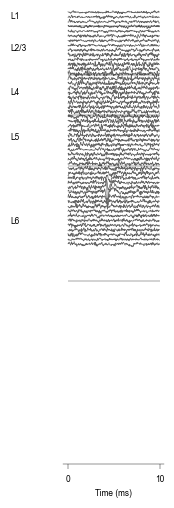

In [24]:
# figure
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)

# probe column 1
pos_up_all = []
pos_up = 0
y_pitch = 0
center_pos_up = 2
c_sites = 0

save_trace_data = []

for ix, c_i in enumerate(col_1_contact_ids):

    pos_up_all.append(pos_up - center_pos_up)

    # do not plot sites outside the cortex
    if pos_up < fig_data["layer_bottom_boundary_to_plot"][4]:
        pass
    else:
        # count sites in cortex
        c_sites += 1
        # ensure we show N_SITES
        # starting from L6
        if c_sites > fig_data["n_sites_in_ctx_col1"] - (N_SITES - 1):
            
            # plot site in cortex
            plt.plot(
                fig_data["trace"][:, c_i] + pos_up,
                linewidth=LINEWIDTH,
                color=COLOR_V,
            )
            save_trace_data.append(fig_data["trace"][:, c_i])
            
    # update depth
    pos_up += PLOT_Y_PITCH


# annotate layers
for ix in range(len(fig_data["annot_layers_pos"])):
    ax.text(
        # 610,
        -190,
        fig_data["annot_layers_pos"][ix],
        "%s" % (str(layers[ix])),
        size=plt.rcParams["font.size"],
        zorder=100,
        color="k",
        ha="left",
    )

# legend
ax.spines[["left", "top", "right"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, DURATION_MS])
ax.set_xlabel("Time (ms)")
ax.set_ylim([-10, Y_MAX + 10])
plt.yticks([])

# plot layer borders
ax.hlines(
    y=fig_data["layer_bottom_boundary_to_plot"][0],
    xmin=0,
    xmax=SAMPFREQ / 1000 * DURATION_MS,
    color="black",
    linewidth=LINEWIDTH_BORD,
)
ax.hlines(
    y=fig_data["layer_bottom_boundary_to_plot"][1],
    xmin=0,
    xmax=SAMPFREQ / 1000 * DURATION_MS,
    color="black",
    linewidth=LINEWIDTH_BORD,
)
ax.hlines(
    y=fig_data["layer_bottom_boundary_to_plot"][2],
    xmin=0,
    xmax=SAMPFREQ / 1000 * DURATION_MS,
    color="black",
    linewidth=LINEWIDTH_BORD,
)
ax.hlines(
    y=fig_data["layer_bottom_boundary_to_plot"][3],
    xmin=0,
    xmax=SAMPFREQ / 1000 * DURATION_MS,
    color="black",
    linewidth=LINEWIDTH_BORD,
)
ax.hlines(
    y=fig_data["layer_bottom_boundary_to_plot"][4],
    xmin=0,
    xmax=SAMPFREQ / 1000 * DURATION_MS,
    color="black",
    linewidth=LINEWIDTH_BORD,
)

number of sites shown: 50


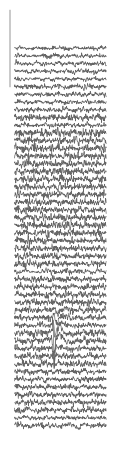

In [25]:
# setup plot
n_sites = len(save_trace_data)

fig, ax = plt.subplots(n_sites, 1, figsize=FIGSIZE)

# allow  vertical overlap of trace axes
fig.subplots_adjust(hspace=-0.9)                        

# plot electrode site voltage traces
for site in range(n_sites):
    flipped_site = n_sites-site-1
    ax[flipped_site].plot(save_trace_data[site], linewidth=LINEWIDTH, color=COLOR_V)
    ax[flipped_site].set_ylim(ylim)
    ax[flipped_site].set_yticks([])
    ax[flipped_site].set_xticks([])
    ax[flipped_site].set_facecolor("none")   # transparent background
    ax[flipped_site].spines[["left", "right", "top","bottom"]].set_visible(False)

print("number of sites shown:", n_sites)

# show voltage scale (ymin and ymax voltage)
ax[0].spines[["left"]].set_visible(True)

# label
#ax[n_sites-1].set_xlabel("Time (ms)");

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/2_dynamics/fig2a_spacetime_vivo_npx.svg", **savefig_cfg
    )